In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
import requests
from sklearn.model_selection import train_test_split
from abc import ABC, abstractmethod

from typing import List, Tuple, Dict

%matplotlib inline

/Users/dqmis/github/code_academy_ai_course/.venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
torch.manual_seed("42")

In [10]:
# read in all the words
words = requests.get(
    "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
).text.splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [22]:
def build_dataset(
    words: List[str], stoi: Dict[str, int], block_size: int = 3
) -> Tuple[torch.Tensor, torch.Tensor]:
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [11]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [25]:
block_size = 3

words_train, words_test = train_test_split(words, test_size=0.2, random_state=42)
words_val, words_test = train_test_split(words_test, test_size=0.5, random_state=42)

Xtr, Ytr = build_dataset(words_train, stoi=stoi, block_size=block_size)
Xval, Yval = build_dataset(words_val, stoi=stoi, block_size=block_size)
Xtest, Ytest = build_dataset(words_test, stoi=stoi, block_size=block_size)

torch.Size([182497, 3]) torch.Size([182497])
torch.Size([22882, 3]) torch.Size([22882])
torch.Size([22767, 3]) torch.Size([22767])


In [26]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print("".join(itos[ix.item()] for ix in x), "-->", itos[y.item()])

... --> i
..i --> n
.in --> d
ind --> i
ndi --> a
dia --> h
iah --> .
... --> m
..m --> e
.me --> l
mel --> a
ela --> .
... --> k
..k --> y
.ky --> l
kyl --> e
yle --> .
... --> e
..e --> r
.er --> i


In [5]:
# --- BASE ---
class Module(ABC):
    @abstractmethod
    def forward(x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError  
    
    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        return self.forward(x)

    @property
    def out(self) -> torch.Tensor:
        return self._out

    @property
    def parameters(self) -> List[torch.Tensor]:
        return []

# --- LINEAR LAYER ---

class Linear(Module):
    def __init__(self, fan_in: int, fan_out: int, bias: bool = True) -> None:
        self._weight = torch.randn(fan_in, fan_out) / fan_in**0.5
        self._bias = torch.zeros(fan_out) if bias else None

    @property
    def weight(self) -> torch.Tensor:
        return self._weight

    @weight.setter
    def weight(self, x: torch.Tensor) -> None:
        self._weight = x
    
    @property
    def bias(self) -> torch.Tensor:
        return self._bias

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        self._out = x @ self._weight
        if self._bias is not None:
            self._out += self.bias
        return self._out

    @property
    def parameters(self) -> List[torch.Tensor]:
        return [self.weight] + ([self.bias] if self.bias is not None else [])


# --- ACTIVATION ---

class Tanh(Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._out = torch.tanh(x)
        return self._out

# --- BATCH NORM ---


class BatchNorm1d(Module):
    def __init__(self, fan_in: int, eps: float = 1e-5, momentum: float = 1e-1) -> None:
        self._eps = eps
        self._momentum = momentum
        self._training = True
        # parameters
        self._gamma = torch.ones(fan_in)
        self._beta = torch.zeros(fan_in)
        # buffers
        self._running_mean = torch.zeros(fan_in)
        self._running_var = torch.ones(fan_in)
    
    @property
    def training(self) -> bool:
        return self._training

    @training.setter
    def training(self, value: bool) -> None:
        self._training = value

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self._training:
            if x.dim == 2:
                dim = 0
            elif x.dim == 3:
                dim = (0, 1)
            xmean = x.mean(dim=dim, keepdim=True)
            xvar = x.var(dim=dim, keepdim=True)
        else:
            xmean = self._running_mean
            xvar = self._running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self._eps)
        self._out = self._gamma * xhat + self._beta

        # updating buffers 
        if self._training:
            self._running_mean = self._momentum * xmean + (1 - self._momentum) * self._running_mean
            self._running_var = self._momentum * xvar + (1 - self._momentum) * self._running_var

        return self._out

    @property
    def parameters(self) -> List[torch.Tensor]:
        return [self._gamma, self._beta]

# --- EMBEDDING ---

class Embedding(Module):
    def __init__(self, vocab_size: int, embedding_size: int) -> None:
        self._embedding = torch.randn(vocab_size, embedding_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._out = self._embedding[x]
        return self._out

    @property
    def parameters(self) -> List[torch.Tensor]:
        return [self._embedding]
    
# --- FLATTEN ---
class Flatten(Module):
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self._out = x.view(x.shape[0], -1)
        return self._out
    
class FlattenConsecutive(Module):
    def __init__(self, n: int = 1) -> None:
        self._n = n

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape
        x = x.view(B, T // self._n, C * self._n)
        if x.shape[1] == 1:
            x = x.squeeze(1)

        self._out = x
        return self._out


# --- SEQUENTIAL ---
class Sequential(Module):
    def __init__(self, *layers: Module) -> None:
        self._layers = list(layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for layer in self._layers:
            x = layer(x)
        self._out = x
        return x

    @property
    def layers(self) -> List[Module]:
        return self._layers

    @property
    def parameters(self) -> List[torch.Tensor]:
        return [p for layer in self._layers for p in layer.parameters]

In [6]:
n_embd = 10
n_hidden = 68

super_block = Sequential(
  FlattenConsecutive(2),
  Linear(n_hidden, n_hidden, bias=False),
  BatchNorm1d(n_hidden),
  Tanh(),
)

In [14]:
print(sum(p.nelement() for p in super_block.parameters[2])) 

68


In [233]:


model = Sequential(
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
)

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22397


In [234]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 1e-1 if i < 150000 else 1e-2
    for p in parameters:
        p.data -= lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d} loss: {loss.item():.3f}")

    lossi.append(loss.item())

      0/ 200000 loss: 3.282
  10000/ 200000 loss: 2.171
  20000/ 200000 loss: 1.905
  30000/ 200000 loss: 2.135
  40000/ 200000 loss: 2.289
  50000/ 200000 loss: 1.923
  60000/ 200000 loss: 2.021
  70000/ 200000 loss: 2.193
  80000/ 200000 loss: 1.985
  90000/ 200000 loss: 2.079
 100000/ 200000 loss: 2.271
 110000/ 200000 loss: 2.483
 120000/ 200000 loss: 2.050
 130000/ 200000 loss: 1.918
 140000/ 200000 loss: 2.085
 150000/ 200000 loss: 1.990
 160000/ 200000 loss: 1.632
 170000/ 200000 loss: 1.820
 180000/ 200000 loss: 2.048
 190000/ 200000 loss: 1.917


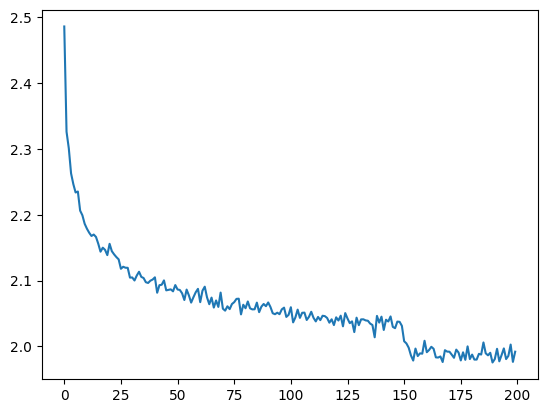

In [235]:
smoothing_gain = 1000
plt.plot(torch.tensor(lossi).view(-1, smoothing_gain).mean(dim=1))

In [236]:
for layer in model.layers:
    layer.training = False

In [237]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'valid': (Xval, Yval),
        'test': (Xtest, Ytest),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('valid')
split_loss('test')

train 1.9454091787338257
valid 2.020329236984253
test 2.0401713848114014


In [238]:
for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
      logits = model(torch.tensor(context).view(1, -1))
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

valiah.
jariah.
lendill.
diak.
brayan.
viily.
janettri.
kienna.
mestoniel.
maiirah.
ashawa.
khani.
steven.
marvik.
sharce.
jladeson.
nahiri.
ashlins.
graleigh.
anushaun.


In [157]:
block_size = 8

words_train, words_test = train_test_split(words, test_size=0.2, random_state=42)
words_val, words_test = train_test_split(words_test, test_size=0.5, random_state=42)

Xtr, Ytr = build_dataset(words_train, stoi=stoi, block_size=block_size)
Xval, Yval = build_dataset(words_val, stoi=stoi, block_size=block_size)
Xtest, Ytest = build_dataset(words_test, stoi=stoi, block_size=block_size)

torch.Size([182497, 8]) torch.Size([182497])
torch.Size([22882, 8]) torch.Size([22882])
torch.Size([22767, 8]) torch.Size([22767])


In [158]:
n_embd = 10
n_hidden = 200 

model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
])

parameters = model.parameters
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22097


In [159]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 18,  5, 25],
        [ 0,  0,  0, 12,  5, 14, 14,  1],
        [ 0,  0, 16, 18,  5, 19,  3, 15]])

In [161]:
logits.shape

torch.Size([4, 27])

In [162]:
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [163]:
model.layers[1].out.shape

torch.Size([4, 80])

In [164]:
model.layers[2].out.shape

torch.Size([4, 200])

In [166]:
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [167]:
list(range(10))[0::2]

[0, 2, 4, 6, 8]

In [172]:
e = torch.randn(4, 8, 10)

In [182]:
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
explicit.shape

torch.Size([4, 4, 20])

In [185]:
(e.view(4, 4, 20) == explicit).all()

tensor(True)